<h1> <Center> <u> Rental Bike Demand Analysis for BoomBikes </u> </Center> </h1>

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.set_option("display.max_columns", None)

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error

from statsmodels.tools.tools import add_constant
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [2]:
bike = pd.read_csv("day.csv")
bike

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,726,27-12-2019,1,1,12,0,4,1,2,10.420847,11.33210,65.2917,23.458911,247,1867,2114
726,727,28-12-2019,1,1,12,0,5,1,2,10.386653,12.75230,59.0000,10.416557,644,2451,3095
727,728,29-12-2019,1,1,12,0,6,0,2,10.386653,12.12000,75.2917,8.333661,159,1182,1341
728,729,30-12-2019,1,1,12,0,0,0,1,10.489153,11.58500,48.3333,23.500518,364,1432,1796


#### Description of Variables in Dataset
    - instant: record index
	- dteday : date
	- season : season (1:spring, 2:summer, 3:fall, 4:winter)
	- yr : year (0: 2018, 1:2019)
	- mnth : month ( 1 to 12)
	- holiday : weather day is a holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
	- weekday : day of the week
	- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
	- weathersit : 
		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
	- temp : temperature in Celsius
	- atemp: feeling temperature in Celsius
	- hum: humidity
	- windspeed: wind speed
	- casual: count of casual users
	- registered: count of registered users
	- cnt: count of total rental bikes including both casual and registered

In [3]:
bike.shape

(730, 16)

In [4]:
bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


There are no missing values. Hence, no data cleaning required.

In [5]:
#Dropping the redundant variables
# holiday is redundant as the workingday column covers that information.
# dteday is not needed as we have useful variables like yr and month. 
#instant is just an index variable and hence isn't needed.
# casual+registered=cnt and cnt is our target variabl2. Hence,can't consider casual and registered columns as independent variables.
bike.drop(['holiday','dteday','instant', 'casual','registered'],axis=1,inplace=True)

In [6]:
#converting object data type variables to correct type
#the only object dtype variable is dteday and converting it to datetime
#bike['dteday'] =  pd.to_datetime(bike['dteday'],format='%d-%m-%Y')
#bike['dteday'].dtype

In [7]:
#Extracting year and month from date
#bike['year'] = bike['dteday'].dt.year
#bike['month'] = bike['dteday'].dt.month

### Visualizing the Data

In [8]:
# Converting necessary numerical variables to categorical variables
bike['season'].replace({1:"spring",2:"summer",3:"fall",4:"winter"},inplace=True)
bike['weathersit'].replace({1:'Clear',2:'Misty or Cloudy',3:'Light Precipitation',4:'Heavy Precipitation'}, inplace=True)
bike['weekday'].replace({5:"Sunday",6:"Monday",0:"Tuesday",1:"Wednesday",2:"Thursday",3:"Friday",4:"Saturday"},inplace=True)

In [9]:
bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      730 non-null    object 
 1   yr          730 non-null    int64  
 2   mnth        730 non-null    int64  
 3   weekday     730 non-null    object 
 4   workingday  730 non-null    int64  
 5   weathersit  730 non-null    object 
 6   temp        730 non-null    float64
 7   atemp       730 non-null    float64
 8   hum         730 non-null    float64
 9   windspeed   730 non-null    float64
 10  cnt         730 non-null    int64  
dtypes: float64(4), int64(4), object(3)
memory usage: 62.9+ KB


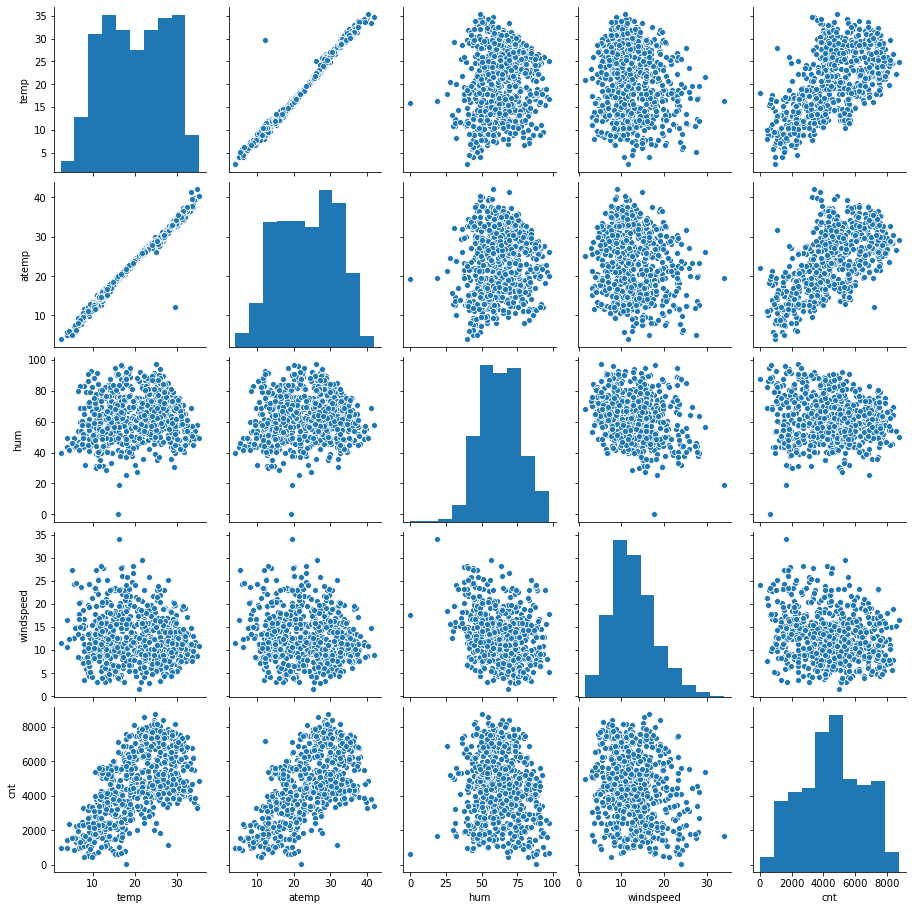

In [10]:
# Visualizing continuous variables using pair plot
sns.pairplot(bike, vars=['temp','atemp','hum','windspeed',"cnt"])
plt.show()

#### Obeservations: 
- There is a linear relationship between the variables temp, atemp, hum, windspeed with the target variable cnt. Hence Linear regression can be used to build a model for predictions.
- The variables, temp and atemp are exhibiting a positive relationship. Hence, their correlation need to checked to avoid multi-collinearity.

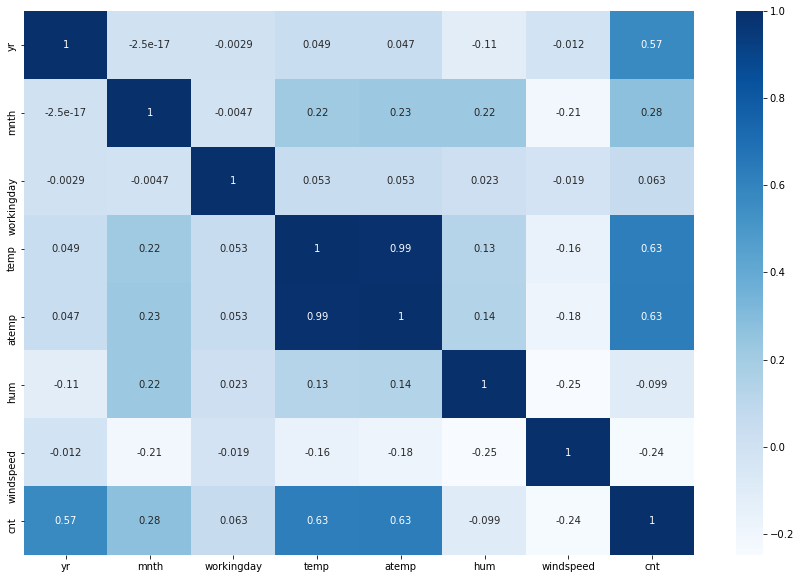

In [11]:
# from above graph it's clear that temp and atemp variables are exhibiting a positive relationship
# Hence plotting heatmap to check the correlation
plt.figure(figsize = (15, 10))
sns.heatmap(bike.corr(), annot = True, cmap="Blues")
plt.show()

temp and atemp are highly positively correlated with a value of 0.99. Hence calculating VIF to find which variable to drop.

In [12]:
# selecting only numeric variable columns
vars = bike[['temp','atemp','hum','windspeed',"cnt"]]
X = add_constant(vars)
pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns)

const        52.978017
temp         62.993716
atemp        63.935491
hum           1.178404
windspeed     1.187971
cnt           1.862057
dtype: float64

Since atemp has a higher VIF, dropping that column to avoid muticollinearity.

In [13]:
bike.drop(['atemp'],axis=1,inplace=True)

In [14]:
bike

,season,yr,mnth,weekday,workingday,weathersit,temp,hum,windspeed,cnt
0,spring,0,1,Monday,0,Misty or Cloudy,14.110847,80.5833,10.749882,985
1,spring,0,1,Tuesday,0,Misty or Cloudy,14.902598,69.6087,16.652113,801
2,spring,0,1,Wednesday,1,Clear,8.050924,43.7273,16.636703,1349
3,spring,0,1,Thursday,1,Clear,8.200000,59.0435,10.739832,1562
4,spring,0,1,Friday,1,Clear,9.305237,43.6957,12.522300,1600
...,...,...,...,...,...,...,...,...,...,...
725,spring,1,12,Saturday,1,Misty or Cloudy,10.420847,65.2917,23.458911,2114
726,spring,1,12,Sunday,1,Misty or Cloudy,10.386653,59.0000,10.416557,3095
727,spring,1,12,Monday,0,Misty or Cloudy,10.386653,75.2917,8.333661,1341
728,spring,1,12,Tuesday,0,Clear,10.489153,48.3333,23.500518,1796


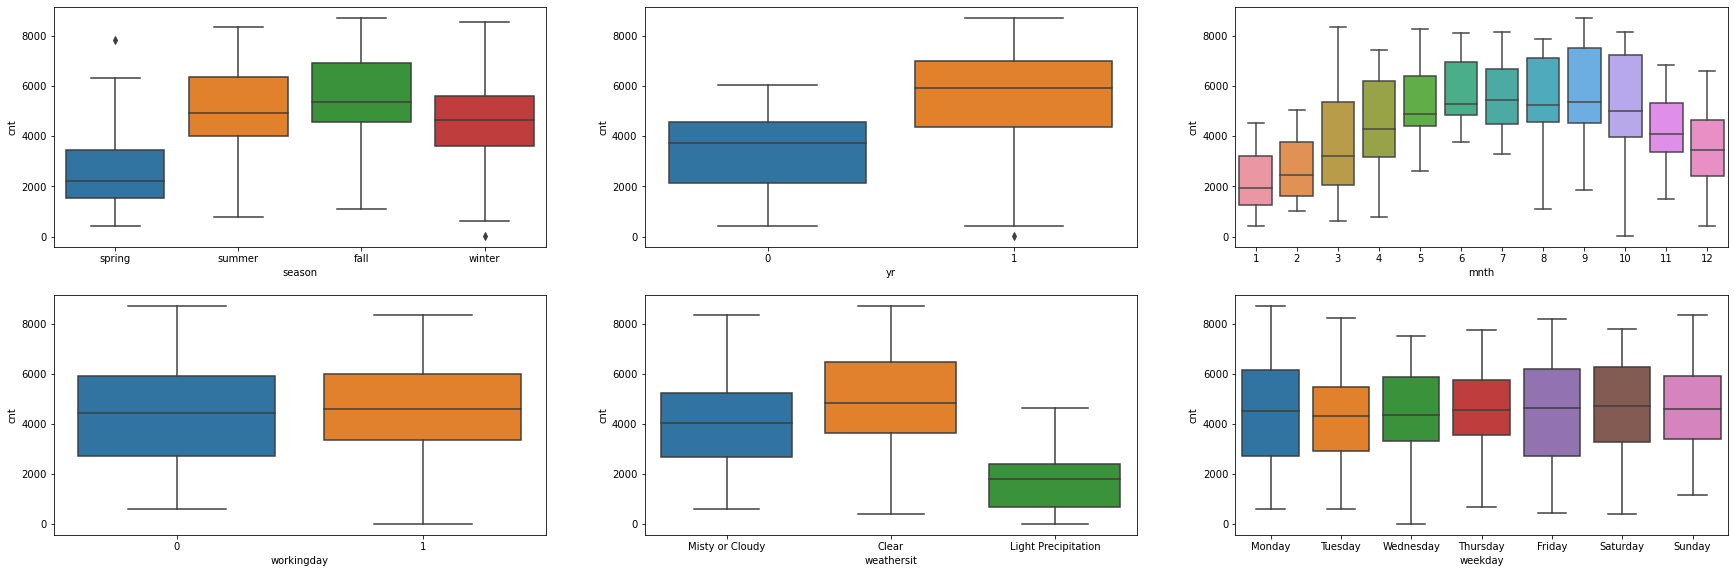

In [15]:
#visualizing categorical variables with respect to target variable cnt using box plot
plt.figure(figsize=(30, 15))
plt.subplot(3,3,1)
sns.boxplot(x = 'season', y = 'cnt', data = bike)
plt.subplot(3,3,2)
sns.boxplot(x = 'yr', y = 'cnt', data = bike)
plt.subplot(3,3,3)
sns.boxplot(x = 'mnth', y = 'cnt', data = bike)
plt.subplot(3,3,4)
sns.boxplot(x = 'workingday', y = 'cnt', data = bike)
plt.subplot(3,3,5)
sns.boxplot(x = 'weathersit', y = 'cnt', data = bike)
plt.subplot(3,3,6)
sns.boxplot(x = 'weekday', y = 'cnt', data = bike)
plt.show()

#### Obeservations: 
- There is a linear trend between independent categorical variables and the target variable cnt
- season, yr, month, and weathersit appear to have a major influence on the demand of bike rental compared to to working day and weekday.

In [16]:
# Analysing Effect of categorical variables on target variable, cnt.
# function to create bar plot of categorical variables with respect to the target variable
def bar_cat(feature):
    sns.barplot(feature,'cnt',data=bike)
    plt.title("Count vs "+str(feature)+" feature")
    plt.show()
    
# function to generate Statistical summary of the relationship between each categoric variable and target variable
def stats_cat(feature):
    cat = bike.groupby(feature)['cnt'].agg(['sum', 'mean','count']).sort_values('sum',ascending = False)
    cat['sum in %']=cat['sum']/bike.cnt.sum()*100
    cat['count in %']=cat['count']/bike.cnt.count()*100
    return round(cat,2)
            

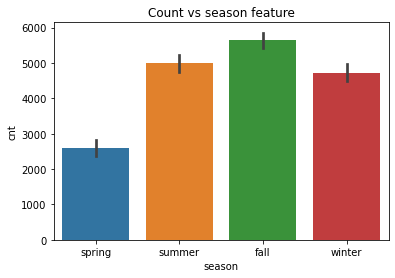

            sum     mean  count  sum in %  count in %
season                                               
fall    1061129  5644.30    188     32.24       25.75
summer   918589  4992.33    184     27.91       25.21
winter   841613  4728.16    178     25.57       24.38
spring   469514  2608.41    180     14.27       24.66


In [17]:
# Season Vs Count
bar_cat('season')
print(stats_cat('season'))

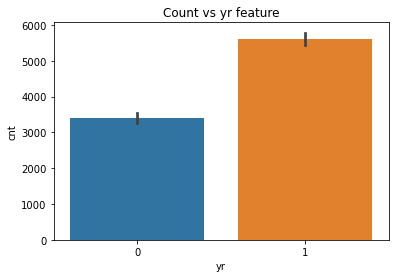

        sum     mean  count  sum in %  count in %
yr                                               
1   2047742  5610.25    365     62.23        50.0
0   1243103  3405.76    365     37.77        50.0


In [18]:
# Year Vs Count
bar_cat('yr')
print(stats_cat('yr'))

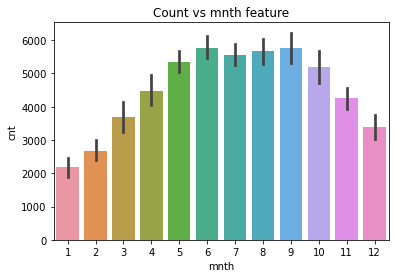

         sum     mean  count  sum in %  count in %
mnth                                              
8     351194  5664.42     62     10.67        8.49
6     346342  5772.37     60     10.52        8.22
9     345991  5766.52     60     10.51        8.22
7     344948  5563.68     62     10.48        8.49
5     331686  5349.77     62     10.08        8.49
10    322352  5199.23     62      9.80        8.49
4     269094  4484.90     60      8.18        8.22
11    254831  4247.18     60      7.74        8.22
3     228920  3692.26     62      6.96        8.49
12    211036  3403.81     62      6.41        8.49
2     149518  2669.96     56      4.54        7.67
1     134933  2176.34     62      4.10        8.49


In [19]:
# Month Vs Count
bar_cat('mnth')
print(stats_cat('mnth'))

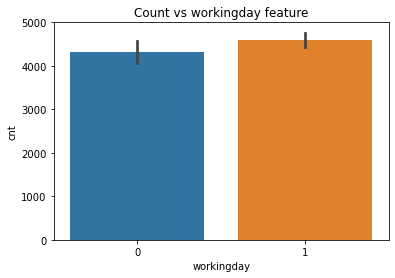

                sum     mean  count  sum in %  count in %
workingday                                               
1           2290576  4590.33    499      69.6       68.36
0           1000269  4330.17    231      30.4       31.64


In [20]:
# Working day Vs Count
bar_cat('workingday')
print(stats_cat('workingday'))

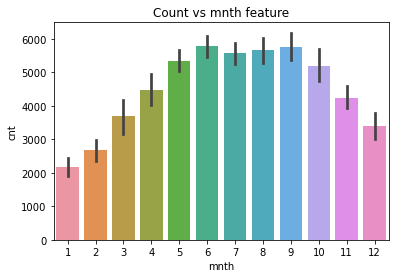

,sum,mean,count,sum in %,count in %
mnth,,,,,
8,351194,5664.42,62,10.67,8.49
6,346342,5772.37,60,10.52,8.22
9,345991,5766.52,60,10.51,8.22
7,344948,5563.68,62,10.48,8.49
5,331686,5349.77,62,10.08,8.49
10,322352,5199.23,62,9.80,8.49
4,269094,4484.90,60,8.18,8.22
11,254831,4247.18,60,7.74,8.22
3,228920,3692.26,62,6.96,8.49


In [21]:
# Month Vs Count 
bar_cat('mnth')
stats_cat('mnth')

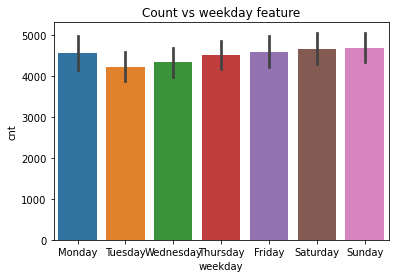

              sum     mean  count  sum in %  count in %
weekday                                                
Sunday     487790  4690.29    104     14.82       14.25
Saturday   485395  4667.26    104     14.75       14.25
Monday     477807  4550.54    105     14.52       14.38
Friday     471214  4574.89    103     14.32       14.11
Thursday   469109  4510.66    104     14.25       14.25
Wednesday  455503  4338.12    105     13.84       14.38
Tuesday    444027  4228.83    105     13.49       14.38


In [22]:
# Week day Vs Count
bar_cat('weekday')
print(stats_cat('weekday'))

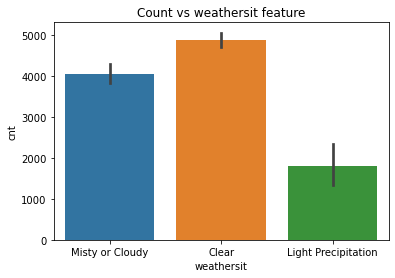

                         sum     mean  count  sum in %  count in %
weathersit                                                        
Clear                2257952  4876.79    463     68.61       63.42
Misty or Cloudy       995024  4044.81    246     30.24       33.70
Light Precipitation    37869  1803.29     21      1.15        2.88


In [23]:
# Weather Vs Count
bar_cat('weathersit')
print(stats_cat('weathersit'))

#### Observations
From the above graphs it's clear that there a variation in demand of bike rentals with respect to change in season, yr, month, and weathersit while no significant trend has been observed with variation in the variables like working day and weekday.

### Encoding
Creating dummy variables of the format 0 and 1 for the categorical variables, so as to feed them appropriately into LR algorithm.

In [24]:
Season = pd.get_dummies(bike['season'],drop_first=True)
Weather = pd.get_dummies(bike['weathersit'],drop_first=True)
Day = pd.get_dummies(bike['weekday'],drop_first=True)
Month = pd.get_dummies(bike['mnth'],drop_first=True)

In [25]:
bike =pd.concat([bike,Season, Weather, Day, Month],axis=1)
bike

,season,yr,mnth,weekday,workingday,weathersit,temp,hum,windspeed,cnt,spring,summer,winter,Light Precipitation,Misty or Cloudy,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,2,3,4,5,6,7,8,9,10,11,12
0,spring,0,1,Monday,0,Misty or Cloudy,14.110847,80.5833,10.749882,985,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,spring,0,1,Tuesday,0,Misty or Cloudy,14.902598,69.6087,16.652113,801,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,spring,0,1,Wednesday,1,Clear,8.050924,43.7273,16.636703,1349,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,spring,0,1,Thursday,1,Clear,8.200000,59.0435,10.739832,1562,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,spring,0,1,Friday,1,Clear,9.305237,43.6957,12.522300,1600,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,spring,1,12,Saturday,1,Misty or Cloudy,10.420847,65.2917,23.458911,2114,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
726,spring,1,12,Sunday,1,Misty or Cloudy,10.386653,59.0000,10.416557,3095,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
727,spring,1,12,Monday,0,Misty or Cloudy,10.386653,75.2917,8.333661,1341,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
728,spring,1,12,Tuesday,0,Clear,10.489153,48.3333,23.500518,1796,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1


In [26]:
#Deleting the orginal season,weathersit,weekday columns
bike.drop(['season', 'weathersit', 'weekday','mnth'],axis=1,inplace=True)
bike.head()

,yr,workingday,temp,hum,windspeed,cnt,spring,summer,winter,Light Precipitation,Misty or Cloudy,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,2,3,4,5,6,7,8,9,10,11,12
0,0,0,14.110847,80.5833,10.749882,985,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,14.902598,69.6087,16.652113,801,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,8.050924,43.7273,16.636703,1349,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,0,1,8.200000,59.0435,10.739832,1562,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,9.305237,43.6957,12.522300,1600,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Model Creation

In [27]:
# Splitting the data to Train and Test sets
train, test = train_test_split(bike, train_size = 0.7, test_size = 0.3, random_state = 100)

In [28]:
train.head()

,yr,workingday,temp,hum,windspeed,cnt,spring,summer,winter,Light Precipitation,Misty or Cloudy,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,2,3,4,5,6,7,8,9,10,11,12
653,1,1,19.201653,55.8333,12.208807,7534,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
576,1,1,29.246653,70.4167,11.083475,7216,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
426,1,0,16.980847,62.1250,10.792293,4066,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
728,1,0,10.489153,48.3333,23.500518,1796,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
482,1,0,15.443347,48.9583,8.708325,4220,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [29]:
train.shape

(510, 28)

In [30]:
test.head()

,yr,workingday,temp,hum,windspeed,cnt,spring,summer,winter,Light Precipitation,Misty or Cloudy,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,2,3,4,5,6,7,8,9,10,11,12
184,0,0,29.793347,63.7917,5.459106,6043,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
535,1,1,32.082500,59.2083,7.625404,6211,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
299,0,1,19.270000,81.2917,13.250121,2659,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
221,0,1,31.433347,42.4167,13.417286,4780,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
152,0,1,29.315000,30.5000,19.583229,4968,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [31]:
test.shape

(219, 28)

In [32]:
bike.describe()

,yr,workingday,temp,hum,windspeed,cnt,spring,summer,winter,Light Precipitation,Misty or Cloudy,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,2,3,4,5,6,7,8,9,10,11,12
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,0.500000,0.683562,20.319259,62.765175,12.763620,4508.006849,0.246575,0.252055,0.243836,0.028767,0.336986,0.143836,0.142466,0.142466,0.142466,0.143836,0.143836,0.076712,0.084932,0.082192,0.084932,0.082192,0.084932,0.084932,0.082192,0.084932,0.082192,0.084932
std,0.500343,0.465405,7.506729,14.237589,5.195841,1936.011647,0.431313,0.434490,0.429689,0.167266,0.473004,0.351164,0.349767,0.349767,0.349767,0.351164,0.351164,0.266317,0.278971,0.274845,0.278971,0.274845,0.278971,0.278971,0.274845,0.278971,0.274845,0.278971
min,0.000000,0.000000,2.424346,0.000000,1.500244,22.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,13.811885,52.000000,9.041650,3169.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.500000,1.000000,20.465826,62.625000,12.125325,4548.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,26.880615,72.989575,15.625589,5966.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,35.328347,97.250000,34.000021,8714.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [33]:
#Scaling Numeric data using MinMax scalar as it will not affect dummy variables
scaler=MinMaxScaler()
num_vars=['temp','hum','windspeed','cnt']
train[num_vars] = scaler.fit_transform(train[num_vars])
train.head()

,yr,workingday,temp,hum,windspeed,cnt,spring,summer,winter,Light Precipitation,Misty or Cloudy,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,2,3,4,5,6,7,8,9,10,11,12
653,1,1,0.509887,0.575354,0.300794,0.864243,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
576,1,1,0.815169,0.725633,0.264686,0.827658,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
426,1,0,0.442393,0.640189,0.255342,0.465255,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
728,1,0,0.245101,0.498067,0.663106,0.204096,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
482,1,0,0.395666,0.504508,0.188475,0.482973,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [34]:
#Splitting the train data into independent(x) variables and target(y) variable.
y_train = train.pop('cnt')
x_train = train

In [35]:
x_train.head()

,yr,workingday,temp,hum,windspeed,spring,summer,winter,Light Precipitation,Misty or Cloudy,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,2,3,4,5,6,7,8,9,10,11,12
653,1,1,0.509887,0.575354,0.300794,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
576,1,1,0.815169,0.725633,0.264686,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
426,1,0,0.442393,0.640189,0.255342,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
728,1,0,0.245101,0.498067,0.663106,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
482,1,0,0.395666,0.504508,0.188475,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [36]:
y_train.head()

653    0.864243
576    0.827658
426    0.465255
728    0.204096
482    0.482973
Name: cnt, dtype: float64

In [37]:
# Fitting the linear regression on train dataset
lm = LinearRegression()
lm.fit(x_train, y_train)
#Selecting features using RFE
rfe = RFE(lm)
rfe = rfe.fit(x_train, y_train)

In [38]:
# Displaying influence of each of the independent variable using rfe ranking
list(zip(x_train.columns,rfe.support_,rfe.ranking_))

[('yr', True, 1),
 ('workingday', False, 5),
 ('temp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('spring', True, 1),
 ('summer', False, 7),
 ('winter', True, 1),
 ('Light Precipitation', True, 1),
 ('Misty or Cloudy', True, 1),
 ('Monday', False, 4),
 ('Saturday', False, 15),
 ('Sunday', False, 14),
 ('Thursday', False, 13),
 ('Tuesday', False, 6),
 ('Wednesday', False, 12),
 (2, False, 8),
 (3, True, 1),
 (4, True, 1),
 (5, True, 1),
 (6, True, 1),
 (7, False, 9),
 (8, False, 2),
 (9, True, 1),
 (10, False, 3),
 (11, False, 10),
 (12, False, 11)]

In [39]:
# Selecting the influencing independent variables from the rfe ranking list
select = x_train.columns[rfe.support_]
select

Index([                 'yr',                'temp',                 'hum',
                 'windspeed',              'spring',              'winter',
       'Light Precipitation',     'Misty or Cloudy',                     3,
                           4,                     5,                     6,
                           9],
      dtype='object')

In [40]:
# Assigning the selected varaibles to the x data to build the actual model
x_train_rfe = x_train[select]
# adding the constant
x_train_rfe = sm.add_constant(x_train_rfe)
#Fitting the data using Linear Regression to build model
lm = sm.OLS(y_train,x_train_rfe).fit()   
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     195.8
Date:                Wed, 03 Nov 2021   Prob (F-statistic):          1.03e-185
Time:                        19:20:54   Log-Likelihood:                 500.91
No. Observations:                 510   AIC:                            -973.8
Df Residuals:                     496   BIC:                            -914.5
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.2963    

In [41]:
# Dropping 6 from x_train_lm because it's p-value is higher than 0.05, and hence it's not significant
x_train_rfe = x_train_rfe.drop(6, axis =1)
x_train_rfe = sm.add_constant(x_train_rfe)
lm = sm.OLS(y_train, x_train_rfe).fit()
print(lm.summary())
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
X = x_train_rfe
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     210.7
Date:                Wed, 03 Nov 2021   Prob (F-statistic):          3.93e-186
Time:                        19:20:54   Log-Likelihood:                 499.12
No. Observations:                 510   AIC:                            -972.2
Df Residuals:                     497   BIC:                            -917.2
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.3055    

,Features,VIF
0,const,68.21
5,spring,3.68
2,temp,3.24
6,winter,2.56
3,hum,1.92
8,Misty or Cloudy,1.56
10,4,1.53
11,5,1.29
7,Light Precipitation,1.24
4,windspeed,1.21


Now all p-values are within the acceptable range of <0.05. Checking the VIF values to ensure they are in acceptable range.

In [42]:
#Dropping constant to see VIF of other variables to check whether all fall within the acceptable range.
x_train_rfe = x_train_rfe.drop('const', axis =1)
vif = pd.DataFrame()
X = x_train_rfe
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,hum,25.45
1,temp,14.46
3,windspeed,4.65
4,spring,3.33
5,winter,2.73
7,Misty or Cloudy,2.25
0,yr,2.09
9,4,1.46
10,5,1.39
8,3,1.28


#### Assumptions made while creating a Linear Regression Model as below:
- The predicted values have linear relationship with the actual values.
- The error terms are normally distributed.
- The training and testing accuracy are nearly equal hence there is no Overfit/Underfit situation.

Humidity and temperature have higher than acceptable VIF value. Hence, need to drop atleast one of these and need to create the model again. Since, humidity has the highest VIF, dropping it.

In [43]:
x_train_rfe = x_train_rfe.drop('hum', axis =1)
x_train_rfe = sm.add_constant(x_train_rfe)
lm = sm.OLS(y_train, x_train_rfe).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     221.0
Date:                Wed, 03 Nov 2021   Prob (F-statistic):          1.37e-183
Time:                        19:20:54   Log-Likelihood:                 490.29
No. Observations:                 510   AIC:                            -956.6
Df Residuals:                     498   BIC:                            -905.8
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.2202    

In [44]:
# Dropping 'const' from x_train_lm
x_train_new = x_train_rfe.drop('const', axis =1)

In [45]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = x_train_new.columns
vif['VIF'] = [variance_inflation_factor(x_train_new.values, i) for i in range(x_train_new.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,windspeed,4.64
1,temp,3.93
0,yr,2.08
3,spring,1.93
4,winter,1.53
6,Misty or Cloudy,1.53
8,4,1.33
7,3,1.27
9,5,1.25
10,9,1.20


Now all p-values as well as VIF are within the acceptable range of <0.05 and <5 respectively. Hence, the final model is suitable and good fit to use for predictions.

### Residual Analysis of the train data
Checking whether the error terms are normally distributed so as to satify all the major assumptions of linear regression.

In [46]:
y_train_pred = lm.predict(x_train_rfe)

Text(0.5, 0, 'Errors')

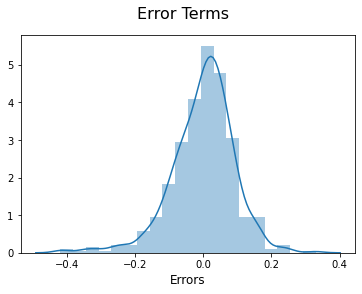

In [47]:
error = y_train - y_train_pred
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot(error, bins = 20)
fig.suptitle('Error Terms', fontsize = 16)                  
plt.xlabel('Errors', fontsize = 12)                      

Text(0.5, 1.0, 'Normal Q-Q Plot')

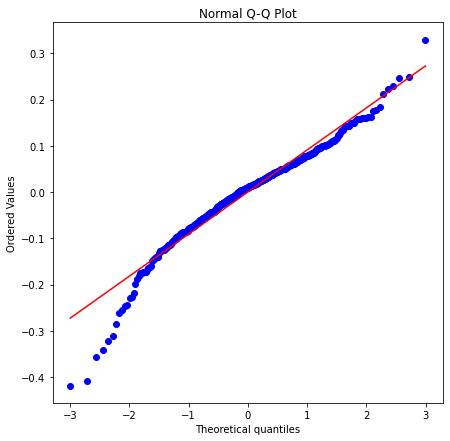

In [48]:
# Plotting Q-Q plot to confirm normal distribution of errors
plt.figure(figsize=(7,7))
stats.probplot(error, dist="norm", plot=plt)
plt.title("Normal Q-Q Plot")

Text(0.5, 1.0, 'Residual plot')

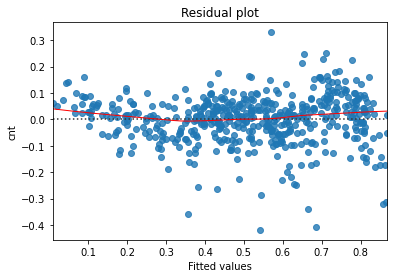

In [49]:
# Plot the scatter plot of the error terms vs 
fig = plt.figure()
sns.residplot(y_train_pred,y_train, lowess=True, line_kws={'color': 'red', 'lw': 1, 'alpha': 1})
plt.xlabel("Fitted values")
plt.title('Residual plot')                   

Text(0.5, 0, 'Fitted value')

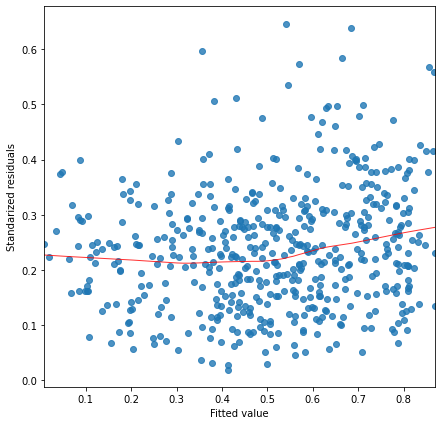

In [50]:
# Plotting Scale-Location plot to verify the homoscedasticity of residuals
norm_residuals_abs_sqrt=np.sqrt(np.abs(error))

plt.figure(figsize=(7,7))
sns.regplot(y_train_pred, norm_residuals_abs_sqrt,
              scatter=True,
              lowess=True,
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plt.ylabel("Standarized residuals")
plt.xlabel("Fitted value")

In [51]:
# Claculating mean of Residuals
round((y_train-y_train_pred).mean(),2)

-0.0

#### Inferences
- The errors are normally distributed.
- The mean of residuals is zero.
- Residuals are homoscedastic.
- The residual plot doesn't indicate any covariance trend in the error.

<b> Hence, it's safe to use the built model for predictions. </b>

### Making Predictions

In [52]:
# Applying the scaling on the test sets
num_vars=['temp', 'hum' ,'windspeed','cnt']
test[num_vars]= scaler.transform(test[num_vars])

In [53]:
y_test = test.pop('cnt')
x_test = test

In [54]:
# Modifying X_test dataframe by dropping variables eliminated variables from X_test and assigning it to a new data frame
X_test = x_test[x_train_new.columns]

# Adding a constant variable 
X_test = sm.add_constant(X_test)

In [55]:
# Making predictions
y_pred = lm.predict(X_test)

### Model Evaluation

Text(0, 0.5, 'y_pred')

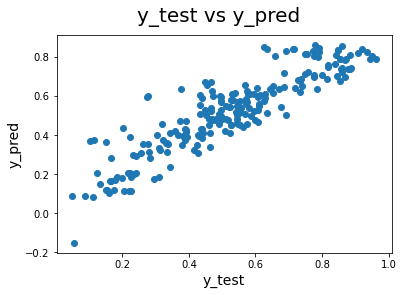

In [56]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_test,y_pred)
fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
plt.xlabel('y_test', fontsize=14)                          # X-label
plt.ylabel('y_pred', fontsize=14)                          # Y-label

In [57]:
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_pred)
print("Rsquared value of train data: ", r2_train )
print("Rsquared value of test data: ", r2_test )

Rsquared value of train data:  0.8299515837258584
Rsquared value of test data:  0.8044113852721477


Text(0.5, 1.0, 'Normal Q-Q Plot')

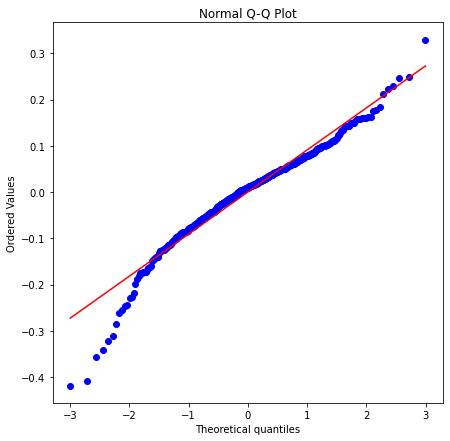

In [58]:
# Plotting Q-Q plot to confirm normal distribution of errors
plt.figure(figsize=(7,7))
stats.probplot(error, dist="norm", plot=plt)
plt.title("Normal Q-Q Plot")

The model has a good R^2 score of 0.804 on the test data, which means that 80.4% of the variation in total number of bike rentals can be explained by the variables in the linear regression model built. Hence, the model well justifies the data, and can be used for decision making.

In [59]:
adj_r2_train = 1-(1-r2_train)*(510-1)/(510-11-1)
adj_r2_test = 1-(1-r2_test)*(219-1)/(219-11-1)
print("Adjusted Rsquared value of train data: ", adj_r2_train )
print("Adjusted Rsquared value of test data : ", adj_r2_test )

Adjusted Rsquared value of train data:  0.8261954942097629
Adjusted Rsquared value of test data :  0.794017787388059


In [60]:
# calculate the mean squared error of train and test data
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_pred)
print('MSE Train: ', mse_train)
print('MSE Test: ', mse_test)

MSE Train:  0.008560734356259899
MSE Test:  0.009289639321493761


### Validating Assumptions of Linear Regression.
The assumptions of linear regression, made to create the model are the following.
- The predicted values have linear relationship with the actual values.
- The error terms are normally distributed.
- The training and testing accuracy are nearly equal hence there is no Overfit/Underfit situation.
- There is no Multicollinearity between two independent variables.
- Homoscedasticity of Residuals.
- There are  at least 20 records of all independent variables.
- All categorical are converted to numeric dummy variables

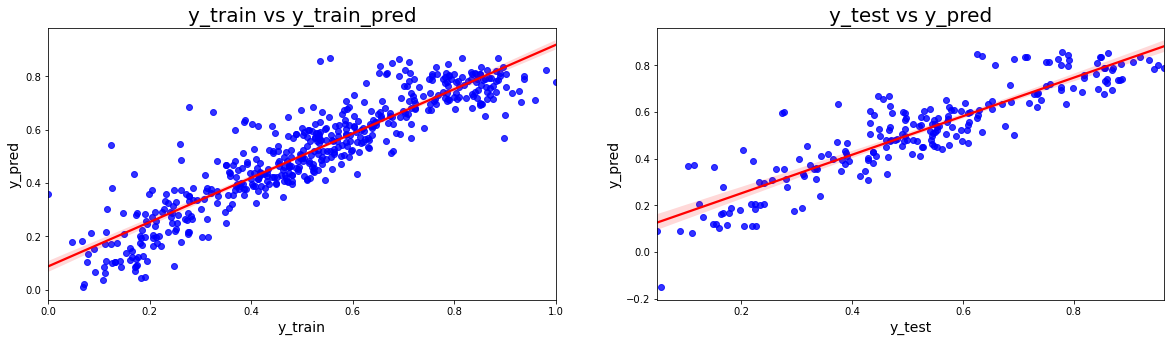

In [61]:
# 1) The predicted values have linear relationship with the actual values.
plt.figure(figsize = (20,5))

plt.subplot(1,2,1)
sns.regplot( y_train, y_train_pred, scatter_kws={"color": "blue"}, line_kws={"color": "red"})
plt.title('y_train vs y_train_pred', fontsize=20)              
plt.xlabel('y_train', fontsize=14)  
plt.ylabel('y_pred', fontsize=14) 

plt.subplot(1,2,2)
sns.regplot( y_test, y_pred, scatter_kws={"color": "blue"}, line_kws={"color": "red"})
plt.title('y_test vs y_pred', fontsize=20)   
plt.xlabel('y_test', fontsize=14)   
plt.ylabel('y_pred', fontsize=14) 

plt.show()

From the Scatter plot it's clear that there is a linear relationship between predicted and actual values of the target variable.

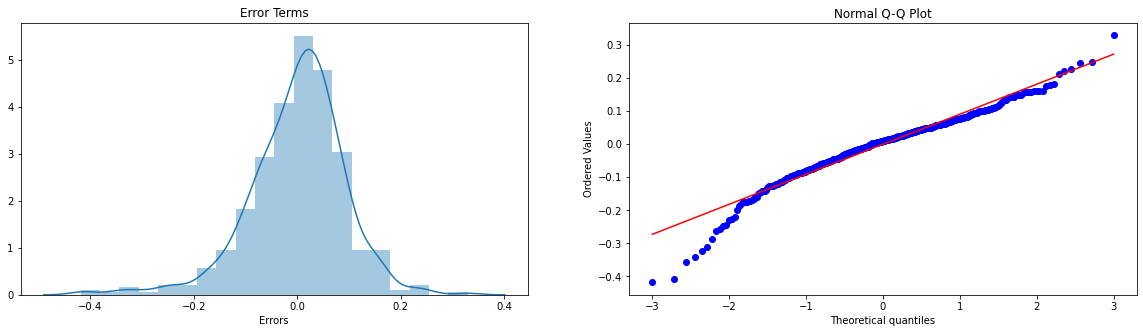

In [62]:
# 2) The error terms are normally distributed.
error = y_train - y_train_pred
plt.figure(figsize = (20,5))

plt.subplot(1,2,1)
sns.distplot(error, bins = 20)
plt.title('Error Terms')                  
plt.xlabel('Errors')    

plt.subplot(1,2,2)
stats.probplot(error, dist="norm", plot=plt)
plt.title("Normal Q-Q Plot")
plt.show()

From the histogram we can clearly see the normal distribution of error terms. This is further confirmed in the Normal Q-Q plot.

In [63]:
# 3) The training and testing accuracy are nearly equal hence there is no Overfit/Underfit situation.
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_pred)
print("Rsquared value of train data: ", r2_train )
print("Rsquared value of test data: ", r2_test )

Rsquared value of train data:  0.8299515837258584
Rsquared value of test data:  0.8044113852721477


The train data has 82.99% accuracy which is very similar to the test accuracy of 80.44%. Hence, we can comclude that there no overfitting or underfitting of the data.

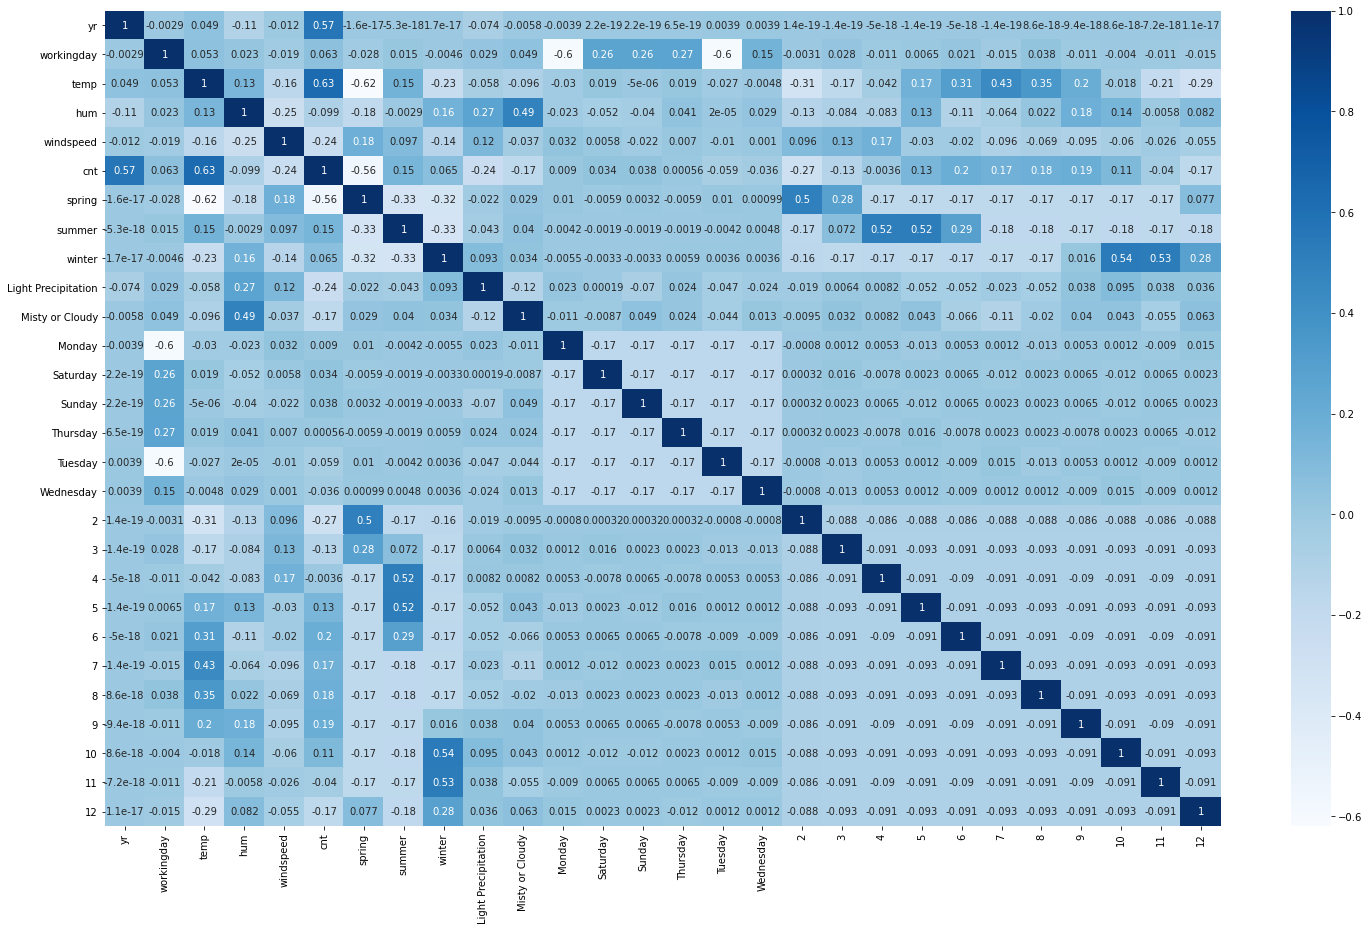

               Features   VIF
2             windspeed  4.64
1                  temp  3.93
0                    yr  2.08
3                spring  1.93
4                winter  1.53
6       Misty or Cloudy  1.53
8                     4  1.33
7                     3  1.27
9                     5  1.25
10                    9  1.20
5   Light Precipitation  1.08


In [64]:
# 4) There is no Multicollinearity between two independent variables.
plt.figure(figsize = (25, 15))
sns.heatmap(bike.corr(), annot = True, cmap="Blues")
plt.show()
print(vif)

From the heatmap it's clear that no variable are highly correlated. Also, from the VIF of the variables we can see there is no multicollinearity between any variables since all VIF values are well within the acceptable range of less than 5.

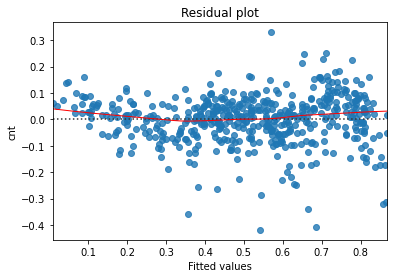

In [65]:
# 5) Homoscedasticity of Residuals.
fig = plt.figure()
sns.residplot(y_train_pred,y_train,lowess=True, line_kws={'color': 'red', 'lw': 1, 'alpha': 1})
plt.xlabel("Fitted values")
plt.title('Residual plot')    
plt.show()

From the residual plot it's clear that there is no visble trend in the distribution of residuals. Hence, the residuals are homoscedastic.

In [66]:
# 6) There are  at least 20 records of all independent variables.
bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   yr                   730 non-null    int64  
 1   workingday           730 non-null    int64  
 2   temp                 730 non-null    float64
 3   hum                  730 non-null    float64
 4   windspeed            730 non-null    float64
 5   cnt                  730 non-null    int64  
 6   spring               730 non-null    uint8  
 7   summer               730 non-null    uint8  
 8   winter               730 non-null    uint8  
 9   Light Precipitation  730 non-null    uint8  
 10  Misty or Cloudy      730 non-null    uint8  
 11  Monday               730 non-null    uint8  
 12  Saturday             730 non-null    uint8  
 13  Sunday               730 non-null    uint8  
 14  Thursday             730 non-null    uint8  
 15  Tuesday              730 non-null    uin

There are 730 records of all independent variables considered in the model.

In [67]:
# 7) All categorical are converted to numeric dummy variables
print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 510 entries, 653 to 79
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   yr                   510 non-null    int64  
 1   workingday           510 non-null    int64  
 2   temp                 510 non-null    float64
 3   hum                  510 non-null    float64
 4   windspeed            510 non-null    float64
 5   spring               510 non-null    uint8  
 6   summer               510 non-null    uint8  
 7   winter               510 non-null    uint8  
 8   Light Precipitation  510 non-null    uint8  
 9   Misty or Cloudy      510 non-null    uint8  
 10  Monday               510 non-null    uint8  
 11  Saturday             510 non-null    uint8  
 12  Sunday               510 non-null    uint8  
 13  Thursday             510 non-null    uint8  
 14  Tuesday              510 non-null    uint8  
 15  Wednesday            510 non-null    ui

There are no categorical variables in the train and test datasets used for model creation. All has been converted to appropriate dummy numeric variables.

### Conclusions

In [68]:
#The final model selected is as below
print(lm.summary())
print(vif)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     221.0
Date:                Wed, 03 Nov 2021   Prob (F-statistic):          1.37e-183
Time:                        19:21:08   Log-Likelihood:                 490.29
No. Observations:                 510   AIC:                            -956.6
Df Residuals:                     498   BIC:                            -905.8
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.2202    

The model has p values and VIF values within the acceptable range of <0.05 and <5 respectively. The model obeys all assumptions of linear regression. 
Based on the above model, the relationship between total number of bike rental and the variables that influence this count can be summarized as follows:

<b> cnt = 0.2347 x yr + 0.4509 x temp - 0.1513 x windspeed -0.0935 x spring + 0.0759 x winter - 0.2854 x Light Precipitation - 0.0789 x Misty or Cloudy + 0.0533 x 3 + 0.0431 x 4 + 0.0558 X 5 + 0.0802 X 9 </b>

- The variables year, temperature, winter, and months March, April, May and September have a positive impact on the count of bike rentals.
- The variables wind speed, spring, Light Precipitation, Misty or Cloudy atmosphere have a negative impact on the count of bike rentals.
- So, bike demand will be high in the months of March, April, May and September especially when temperature is in the higher range and wind speed is low with, low probability of rain and snow as well as a misty or cloudy atmosphere. The demand will be higher in a winter weather compared to summer weather. 
- Also, demand will increase in the upcoming years, compared to previous year.

The model has a good R^2 score of 0.804 on the test data, which means that 80.4% of the variation in total number of bike rentals can be explained by the variables in the linear regression model built. Hence, the model well justifies the data, and can be used for decision making.